In [ ]:
!pip install kagglehub scikit-image opencv-python matplotlib

In [ ]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_niblack, threshold_sauvola
from skimage import img_as_ubyte
import kagglehub

In [ ]:
path = kagglehub.dataset_download("tushartalukder/drive-256")
print("Dataset path:", path)

100%|██████████| 10.9M/10.9M [00:00<00:00, 74.9MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/tushartalukder/drive-256/versions/5


In [ ]:
all_imgs = glob.glob(path + "/**/*.tif", recursive=True) + \
           glob.glob(path + "/**/*.png", recursive=True) + \
           glob.glob(path + "/**/*.jpg", recursive=True)

print("Total files found:", len(all_imgs))

# Separate images and manual vessel masks
mask_paths = [p for p in all_imgs if "manual" in p.lower() or "mask" in p.lower()]
image_paths = [p for p in all_imgs if p not in mask_paths]

image_paths.sort()
mask_paths.sort()

print("Fundus Images:", len(image_paths))
print("Vessel Masks:", len(mask_paths))

Total files found: 240
Fundus Images: 120
Vessel Masks: 120


In [ ]:
def preprocess(img):
    green = img[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(green)
    enhanced = cv2.GaussianBlur(enhanced, (3,3), 0)
    return enhanced

def compute_metrics(pred, gt):
    pred = pred > 0
    gt = gt > 0
    TP = np.sum(pred & gt)
    TN = np.sum(~pred & ~gt)
    FP = np.sum(pred & ~gt)
    FN = np.sum(~pred & gt)
    sensitivity = TP / (TP + FN + 1e-8)
    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-8)

    return sensitivity, accuracy

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

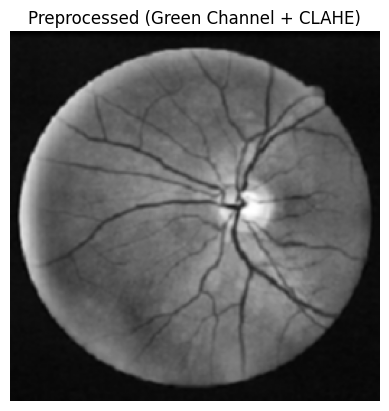

In [ ]:
img = cv2.imread(image_paths[0])
mask = cv2.imread(mask_paths[0], 0)

gray = preprocess(img)

plt.imshow(gray, cmap='gray')
plt.title("Preprocessed (Green Channel + CLAHE)")
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

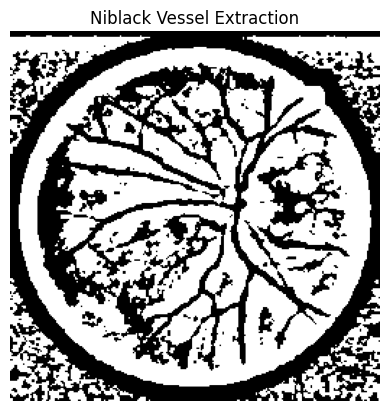

In [ ]:
window = 25

th_niblack = threshold_niblack(gray, window_size=window, k=0.2)
binary_niblack = gray > th_niblack
binary_niblack = img_as_ubyte(binary_niblack)

plt.imshow(binary_niblack, cmap='gray')
plt.title("Niblack Vessel Extraction")
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

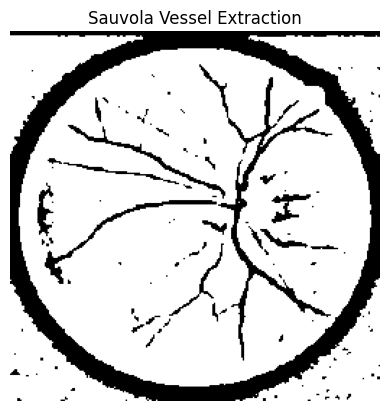

In [ ]:
th_sauvola = threshold_sauvola(gray, window_size=window)
binary_sauvola = gray > th_sauvola
binary_sauvola = img_as_ubyte(binary_sauvola)

plt.imshow(binary_sauvola, cmap='gray')
plt.title("Sauvola Vessel Extraction")
plt.axis("off")

In [ ]:
sens_nib, acc_nib = compute_metrics(binary_niblack, mask)
sens_sau, acc_sau = compute_metrics(binary_sauvola, mask)

print("Niblack Sensitivity (Thin Vessels):", sens_nib)
print("Niblack Accuracy:", acc_nib)

print("Sauvola Sensitivity (Thin Vessels):", sens_sau)
print("Sauvola Accuracy:", acc_sau)

Niblack Sensitivity (Thin Vessels): 0.40418909824999644
Niblack Accuracy: 0.37980651855462955
Sauvola Sensitivity (Thin Vessels): 0.7256056527584743
Sauvola Accuracy: 0.29083251953120565


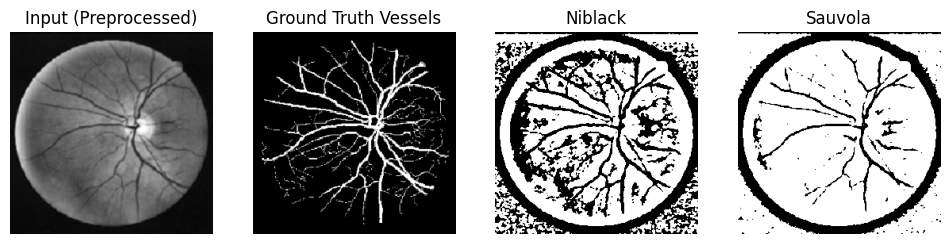

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,4,1)
plt.imshow(gray, cmap='gray')
plt.title("Input (Preprocessed)")

plt.subplot(1,4,2)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth Vessels")

plt.subplot(1,4,3)
plt.imshow(binary_niblack, cmap='gray')
plt.title("Niblack")

plt.subplot(1,4,4)
plt.imshow(binary_sauvola, cmap='gray')
plt.title("Sauvola")

for i in range(4):
    plt.subplot(1,4,i+1).axis("off")

plt.show()

In [ ]:
nib_scores = []
sau_scores = []

num_images = min(10, len(image_paths))

for i in range(num_images):
    img = cv2.imread(image_paths[i])
    mask = cv2.imread(mask_paths[i], 0)

    gray = preprocess(img)

    # Niblack
    th_n = threshold_niblack(gray, window_size=25, k=0.2)
    bin_n = img_as_ubyte(gray > th_n)

    # Sauvola
    th_s = threshold_sauvola(gray, window_size=25)
    bin_s = img_as_ubyte(gray > th_s)

    nib_scores.append(compute_metrics(bin_n, mask)[0])
    sau_scores.append(compute_metrics(bin_s, mask)[0])

print("Average Niblack Sensitivity (Thin Vessels):", np.mean(nib_scores))
print("Average Sauvola Sensitivity (Thin Vessels):", np.mean(sau_scores))

Average Niblack Sensitivity (Thin Vessels): 0.3728391072374824
Average Sauvola Sensitivity (Thin Vessels): 0.8031732229692381
